In [48]:
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import os
import matplotlib.pyplot as plt

In [14]:
database = os.getenv('BikeSharing_DB')
username = os.getenv('BikeSharing_User')
password = os.getenv('BikeSharing_Pass')
host = os.getenv('BikeSharing_Host')
port = os.getenv('BikeSharing_Port')

try:
    connection_string = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"
    engine = create_engine(connection_string)

except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")


In [15]:
query = "SELECT * FROM rides_2022"
df_rides = pd.read_sql(query, connection_string)

query = "SELECT * FROM dim_rideable_type"
df_rideable_type = pd.read_sql(query, connection_string)

query = "SELECT * FROM dim_station"
df_station = pd.read_sql(query, connection_string)

query = "SELECT * FROM dim_user_type"
df_user_type = pd.read_sql(query, connection_string)


In [17]:
#Integrety check
df_rides.isnull().sum()

ride_id                  0
rideable_id              0
started_at               0
ended_at                 0
start_station_id    833064
end_station_id      892742
start_lat                0
start_lng                0
end_lat               5858
end_lng               5858
user_type_id             0
dtype: int64

In [19]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_rides.describe()


,rideable_id,start_lat,start_lng,end_lat,end_lng,user_type_id
count,5667717.00,5667717.00,5667717.00,5661859.00,5661859.00,5667717.00
mean,1.52,41.90,-87.65,41.90,-87.65,1.59
std,0.56,0.05,0.03,0.07,0.11,0.49
min,1.00,41.64,-87.84,0.00,-88.14,1.00
25%,1.00,41.88,-87.66,41.88,-87.66,1.00
50%,1.00,41.90,-87.64,41.90,-87.64,2.00
75%,2.00,41.93,-87.63,41.93,-87.63,2.00
max,3.00,45.64,-73.80,42.37,0.00,2.00


In [54]:
df_rides['duration'].describe()

count                      5667717
mean     0 days 00:19:26.597144670
std      0 days 02:56:07.687857087
min              -8 days +19:26:39
25%                0 days 00:05:49
50%                0 days 00:10:17
75%                0 days 00:18:28
max               28 days 17:47:15
Name: duration, dtype: object

In [61]:

# Convert 'started_at' y 'ended_at' to datetime 
df_rides['started_at'] = pd.to_datetime(df_rides['started_at'])
df_rides['ended_at'] = pd.to_datetime(df_rides['ended_at'])

# Calcular la duración del viaje
df_rides['duration'] = df_rides['ended_at'] - df_rides['started_at']

# Filtrar para eliminar viajes con duración negativa o igual a cero
df_rides_filtered = df_rides[df_rides['duration'] > pd.Timedelta(0)]



In [62]:
# Verify that all durations are greater than 0
assert (df_rides_filtered['duration'] > pd.Timedelta(0)).all(), "There are negative or duration with 00:00:00 in the df."

print("All durations are positive and greater than 0.")


All durations are positive and greater than 0.


In [63]:
df_rides_filtered['duration'].describe()

count                      5667186
mean     0 days 00:19:26.845749901
std      0 days 02:56:04.932799822
min                0 days 00:00:01
25%                0 days 00:05:49
50%                0 days 00:10:17
75%                0 days 00:18:28
max               28 days 17:47:15
Name: duration, dtype: object

In [65]:
# # Convert duration to seconds to calculate std and mean
# duration_seconds = df_rides_filtered['duration'].dt.total_seconds()

# mean_duration = duration_seconds.mean()
# print("mean", mean_duration)
# std_duration = duration_seconds.std()
# print("std", std_duration)

# #Set limits for outliers

# lower_limit = mean_duration - (3 * std_duration)
# upper_limit = mean_duration + (3 * std_duration)

# df_rides_filtered = df_rides_filtered[
#     (duration_seconds >= lower_limit) & (duration_seconds <= upper_limit)]

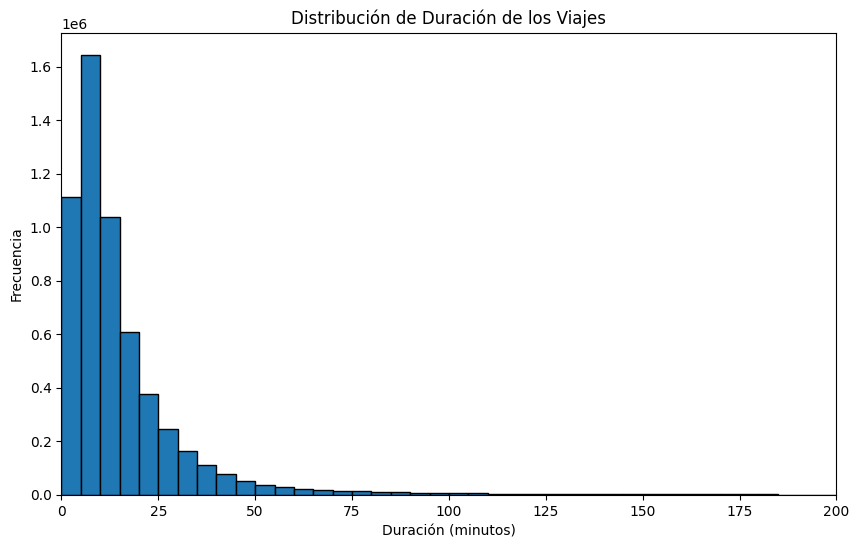

In [73]:
import matplotlib.pyplot as plt

# Convertir la duración a minutos
duration_minutes = df_rides_filtered['duration'].dt.total_seconds() / 60

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(duration_minutes, bins=range(0, 301, 5), edgecolor='black')  # Bins de 5 minutos hasta 300 minutos
plt.title('Distribución de Duración de los Viajes')
plt.xlabel('Duración (minutos)')
plt.ylabel('Frecuencia')
plt.xlim(0, 200)  # Limitar el eje x a 300 minutos

# Mostrar el histograma
plt.show()



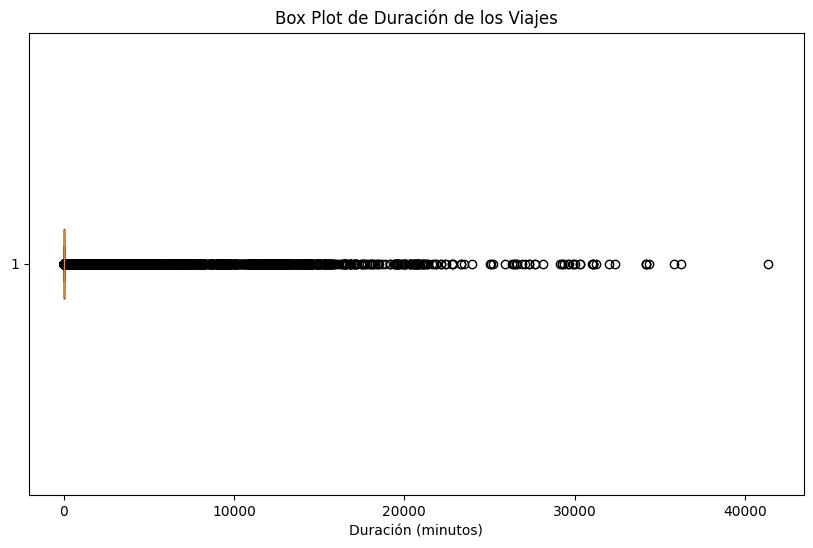

In [74]:
import matplotlib.pyplot as plt

# Asumiendo que duration_minutes ya está calculado
# Convertir la duración a minutos si no lo has hecho
# duration_minutes = df_rides_filtered['duration'].dt.total_seconds() / 60

# Crear el box plot
plt.figure(figsize=(10, 6))
plt.boxplot(duration_minutes, vert=False)  # vert=False para un box plot horizontal
plt.title('Box Plot de Duración de los Viajes')
plt.xlabel('Duración (minutos)')

# Mostrar el box plot
plt.show()


In [75]:
# Cuantiles
q1 = duration_minutes.quantile(0.25)
q3 = duration_minutes.quantile(0.75)
iqr = q3 - q1

print(f"1er Cuartil (Q1): {q1} minutos")
print(f"3er Cuartil (Q3): {q3} minutos")
print(f"Rango Intercuartílico (IQR): {iqr} minutos")


1er Cuartil (Q1): 5.816666666666666 minutos
3er Cuartil (Q3): 18.466666666666665 minutos
Rango Intercuartílico (IQR): 12.649999999999999 minutos


In [79]:
# Límites para identificar valores extremos
lower_limit_iqr = q1 - 1.5 * iqr
upper_limit_iqr = q3 + 1.5 * iqr

print(f"Límite inferior para valores extremos: {lower_limit_iqr} minutos")
print(f"Límite superior para valores extremos: {upper_limit_iqr} minutos")


# Pendiente terminar de calcular los limites y filtrar el df con los limites. posiblemente el limite inferior sea un corte manual en 3'ArithmeticError

Límite inferior para valores extremos: -13.158333333333331 minutos
Límite superior para valores extremos: 37.44166666666666 minutos


In [ ]:
connection_string.close()
